In [1]:
import os
import datetime
import doralite
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import doralite
import glob
import subprocess
import momlevel
import itertools

from datetime import timedelta

print("numpy version  : ", np.__version__)
print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)

config = {
    "startyr": "1",
    "endyr": "100",
    "dora_id": "cm5-3",
    "pathPP": "",
}

for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"]
        if f"MAR_{k.upper()}" in os.environ.keys()
        else v
    )

numpy version  :  1.23.5
pandas version :  1.5.3
xarray version :  2023.3.0


In [2]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

# 1. List of all experiments to consider
experiments = [doralite.dora_metadata(x) for x in config["dora_id"].split(",")]

In [3]:
# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])


print(start,end)

1 100


In [4]:
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

In [34]:
datafiles_ice = []
staticfiles_ice = []

datafiles_ocean = []
staticfiles_ocean = []

for experiment in experiments:
    _pathPP = experiment["pathPP"]
#_pathPP = "/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp/"

    component = "ice"
    static = f"{component}/{component}.static.nc"
    varname = "siconc"

    chunk = "5yr"
    filelist = sorted(glob.glob(f"{_pathPP}{component}/ts/monthly/{chunk}/{component}.*.{varname}.nc"))
    
    filelist_ice = [x for x in filelist if is_in_range(x,start,end)]
    _staticfile_ice = f"{_pathPP}/{static}"

    staticfiles_ice.append(_staticfile_ice)
    datafiles_ice.append(filelist_ice)

    component = "ocean_monthly_z_1x1deg"
    static = f"{component}/{component}.static.nc"
    varname = "thetao"

    filelist = sorted(glob.glob(f"{_pathPP}{component}/ts/monthly/{chunk}/{component}.*.{varname}.nc"))

    filelist_ocean = [x for x in filelist if is_in_range(x,start,end)]
    _staticfile_ocean = f"{_pathPP}/{static}"

    staticfiles_ocean.append(_staticfile_ocean)
    datafiles_ocean.append(filelist_ocean)

## Dmgetting files for ice and ocean

In [114]:
allfiles = sorted(list(itertools.chain(*datafiles_ice)) + staticfiles_ice + list(itertools.chain(*datafiles_ocean)) + staticfiles_ocean)
_ = [print(x) for x in allfiles]

if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+allfiles
    _ = subprocess.check_output(cmd)

/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp//ice/ice.static.nc
/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp//ocean_monthly_z_1x1deg/ocean_monthly_z_1x1deg.static.nc
/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp/ice/ts/monthly/5yr/ice.000101-000512.siconc.nc
/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp/ice/ts/monthly/5yr/ice.001101-001512.siconc.nc
/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp/ice/ts/monthly/5yr/ice.001601-002012.siconc.nc
/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp/ice/ts/monthly/5yr/ice.002101-002512.siconc.nc
/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp/ice/ts/m

## Figure creation -- similar to Held 2019 CM4 documentation figure

/vftmp/Katherine.Turner/pid16509/ipykernel_29560/1371339481.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


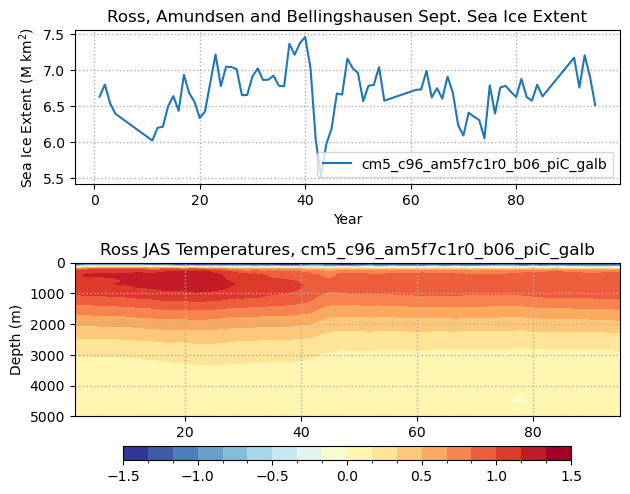

In [125]:
n_rows = len(datafiles_ocean)

fig, axis = plt.subplots(ncols=1, nrows=n_rows+1, dpi=100)

for n,exp in enumerate(experiments):

    expName = exp["expName"]
    
    # Open datasets
    ds_ice = xr.open_mfdataset(datafiles_ice[n], use_cftime=True)
    ds_static_ice = xr.open_dataset(staticfiles_ice[n])

    ds_ocean = xr.open_mfdataset(datafiles_ocean[n], use_cftime=True)
    ds_static_ocean = xr.open_dataset(staticfiles_ocean[n])
    
    # Ice mask and estimate of surface area
    mask_RAB = (ds_static_ice.GEOLAT <= -40) & (ds_static_ice.GEOLON >= -200) & (ds_static_ice.GEOLON <= -60)
    idx_sep = ds_ice.time.dt.month == 9
    dA_Earth = 510e6 # units km^2
    siextent_RAB = (ds_ice.siconc[idx_sep].groupby(ds_ice.time[idx_sep].dt.year).mean() * mask_RAB * ds_static_ice.CELL_AREA).sum(dim=['xT', 'yT'])

    ## ocean masks for Ross Sea and selecting for JAS temperatures
    idx_jas = ds_ocean.time.dt.month.isin([7,8,9])

    thetao_Ross = ds_ocean.thetao.sel(lat=slice(-90,-60)).sel(lon=slice(160,230))
    area_Ross = ds_static_ocean.areacello.sel(lat=slice(-90,-60)).sel(lon=slice(160,230))

    thetao_Ross_JAS = thetao_Ross[idx_jas,:,:,:].groupby(ds_ocean.time[idx_jas].dt.year).mean() 
    thetao_Ross_JAS_avg = (thetao_Ross_JAS * area_Ross).sum(dim=['lat', 'lon'])/area_Ross.sum(dim=['lat','lon'])
    
    #################################################################################################
    ## plotting...
    (1e-6 * dA_Earth * siextent_RAB).plot.line(ax=axis[0], label=expName, linestyle='solid', linewidth=1.5)

    im = thetao_Ross_JAS_avg.plot.contourf(ax=axis[n+1], x='year', vmin=-1.5, vmax=1.5, levels=19, 
                                  cmap="RdYlBu_r", extend="neither", add_colorbar=False)
    axis[n+1].set_title(f'Ross JAS Temperatures, {expName}', fontsize=12)
    axis[n+1].set_ylim([5000, 0])
    axis[n+1].set_ylabel('Depth (m)')
    axis[n+1].set_xlabel('Year')
    axis[n+1].grid(linewidth=1, linestyle="dotted")
    
axis[0].legend(loc='lower right', fontsize=10)
axis[0].set_title('Ross, Amundsen and Bellingshausen Sept. Sea Ice Extent', fontsize=12)
axis[0].set_ylabel('Sea Ice Extent (M km$^2$)')
axis[0].set_xlabel('Year')
axis[0].grid(linewidth=1, linestyle="dotted")

cbar_ax = fig.add_axes([.2, .03, .70, .03])
fig.colorbar(im,cax = cbar_ax, orientation="horizontal", ticks=np.arange(-1.5,2,.5))
plt.tight_layout()

In [79]:
# # Open datasets
# ds_ice = xr.open_mfdataset(filelist_ice, use_cftime=True)
# ds_static_ice = xr.open_dataset(_staticfile_ice)

# ds_ocean = xr.open_mfdataset(filelist_ocean, use_cftime=True)
# ds_static_ocean = xr.open_dataset(_staticfile_ocean)

# ## ice mask and estimate of surface area
# mask_RAB = (ds_static_ice.GEOLAT <= -40) & (ds_static_ice.GEOLON >= -200) & (ds_static_ice.GEOLON <= -60)

# idx_sep = ds_ice.time.dt.month == 9

# dA_Earth = 510e6 # units km^2

# siextent_RAB = (ds_ice.siconc[idx_sep].groupby(ds_ice.time[idx_sep].dt.year).mean() * mask_RAB * ds_static_ice.CELL_AREA).sum(dim=['xT', 'yT'])

# ## ocean mask for Ross Sea
# idx_jas = ds_ocean.time.dt.month.isin([7,8,9])

# # If using 1x1deg diagnostics ---
# thetao_Ross = ds_ocean.thetao.sel(lat=slice(-90,-60)).sel(lon=slice(160,230))
# area_Ross = ds_static_ocean.areacello.sel(lat=slice(-90,-60)).sel(lon=slice(160,230))

# thetao_Ross_JAS = thetao_Ross[idx_jas,:,:,:].groupby(ds_ocean.time[idx_jas].dt.year).mean() 

# thetao_Ross_JAS_avg = (thetao_Ross_JAS * area_Ross).sum(dim=['lat', 'lon'])/area_Ross.sum(dim=['lat','lon'])

/vftmp/Katherine.Turner/pid16509/ipykernel_29560/4270018063.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


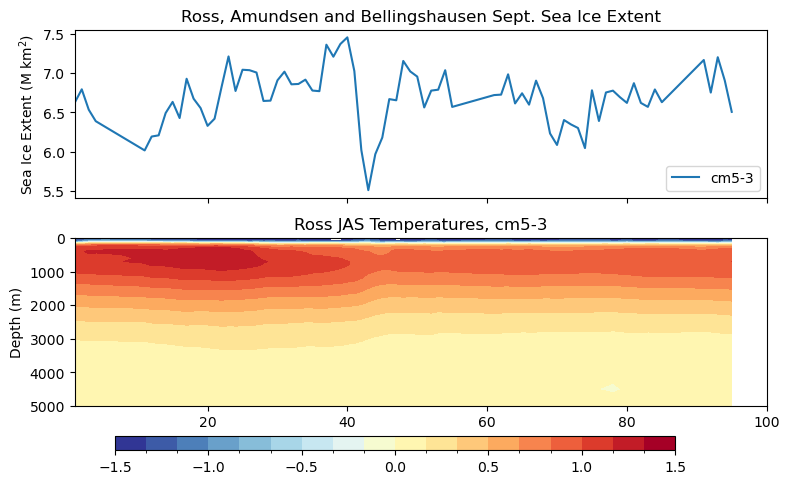

In [122]:
# fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(8,4.7), dpi=100, sharex=True)

# (1e-6 * dA_Earth * siextent_RAB).plot.line(ax=axis[0], label='cm5-3', linestyle='solid', linewidth=1.5)
# axis[0].legend(loc='lower right', fontsize=10)
# axis[0].set_title('Ross, Amundsen and Bellingshausen Sept. Sea Ice Extent', fontsize=12)
# axis[0].set_ylabel('Sea Ice Extent (M km$^2$)')
# axis[0].set_xlabel('')
# axis[0].set_xlim([start, end])


# im = thetao_Ross_JAS_avg.plot.contourf(ax=axis[1], x='year', vmin=-1.5, vmax=1.5, levels=19, 
#                                   cmap="RdYlBu_r", extend="neither", add_colorbar=False)
# axis[1].set_title('Ross JAS Temperatures, cm5-3', fontsize=12)
# axis[1].set_ylim([5000, 0])
# axis[1].set_ylabel('Depth (m)')
# axis[1].set_xlim([start, end])

# cbar_ax = fig.add_axes([.15, .03, .70, .03])
# fig.colorbar(im,cax =cbar_ax, orientation="horizontal", ticks=np.arange(-1.5,2,.5))
# plt.tight_layout()